<a href="https://colab.research.google.com/github/nick-leland/mit-deep-learning-capstone/blob/main/Facial_Recognition_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt

import jax
print(jax.__version__)

import sys
import numpy as np

0.4.26


In [2]:
# Check if we are within a colab environment
IN_COLAB = 'google.colab' in sys.modules

In [3]:
# If running on a colab server, mount the drive
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Unzip the Facial_Emotion_images dataset
if IN_COLAB:
  !unzip -oq /content/drive/MyDrive/Facial_emotion_images.zip

In [5]:
# Assuming the dataset is already unzipped
path = os.path.relpath("/content/Facial_emotion_images")
files = os.listdir(path)

# This should contain our Train/Test/Split
files

['test', 'validation', 'train']

In [6]:
# Now we will take a look at the contents in one of these folders.
emotions = os.listdir(path+"/test")
emotions

['sad', 'surprise', 'happy', 'neutral']

In [7]:
# Generates a list file for the files within the folder
sample_files = os.listdir(path + "/test/" + emotions[0])
len(sample_files)

32

In [8]:
# Generates the path to above file locations
current_path = (path + "/test/" + emotions[0])
current_path

'Facial_emotion_images/test/sad'

In [9]:
x = np.asarray(Image.open(current_path + "/" + sample_files[0]))
x.shape

(48, 48)

In [10]:
np.max(x), np.min(x)

(255, 17)

In [11]:
# Initialize the empty lists we will sorth these files within
data, final = {}, {}

# First we will go through each datatype (test/train/validation)
for datatype in files:

    # We will generate these layer files to cumulatively update the directory path
    layer2 = path + "/" + datatype

    # Now we cycle through each emotion (Already defined as a list previously)
    for emotion in emotions:
        layer3 = layer2 + "/" + emotion

        # Update our initial data dictionary to add the empty list we will fill with arrays
        data.update({f"{datatype}_{emotion}":[]})

        # We first list all the files in our current rolling directory path
        sample_files = os.listdir(layer3)

        # Then we iterate through that target list
        for images in sample_files:
            data[f"{datatype}_{emotion}"].append(np.asarray(Image.open(layer3 + "/" + images)))
        final.update({f"{datatype}_{emotion}" : np.stack(data[f"{datatype}_{emotion}"])})

In [12]:
# Let's convert the data to individual variables to evaluate distributions
test_happy = final["test_happy"]
test_sad = final["test_sad"]
test_surprise = final["test_surprise"]
test_neutral = final["test_neutral"]
train_happy = final["train_happy"]
train_sad = final["train_sad"]
train_surprise = final["train_surprise"]
train_neutral = final["train_neutral"]
validation_happy = final["validation_happy"]
validation_sad = final["validation_sad"]
validation_surprise = final["validation_surprise"]
validation_neutral = final["validation_neutral"]

# Let us evaluate one of these files just to ensure the conversion went correctly.
[print(final[x].shape) for x in final.keys()]
print(type(train_happy))

(32, 48, 48)
(32, 48, 48)
(32, 48, 48)
(32, 48, 48)
(1139, 48, 48)
(797, 48, 48)
(1825, 48, 48)
(1216, 48, 48)
(3982, 48, 48)
(3173, 48, 48)
(3976, 48, 48)
(3978, 48, 48)
<class 'numpy.ndarray'>


In [13]:
# Next we will be creating our general X and Y classes

# Use the jnp.concat command to generate our independent variables
test_x = np.concatenate((test_happy, test_sad, test_surprise, test_neutral))
train_x = np.concatenate((train_happy, train_sad, train_surprise, train_neutral))
validation_x = np.concatenate((validation_happy, validation_sad, validation_surprise, validation_neutral))

In [14]:
# Here we will verify that the we maintain the 48x48 image shape
test_x.shape, train_x.shape, validation_x.shape

((128, 48, 48), (15109, 48, 48), (4977, 48, 48))

In [15]:
# We will now perform a similar task to generate our Target Variable output.
# It is important that we concat these in the same order as the previous cell
test_y = np.concatenate([
    np.full(test_happy.shape[0], 0),
    np.full(test_sad.shape[0], 1),
    np.full(test_surprise.shape[0], 2),
    np.full(test_neutral.shape[0], 3)
])

train_y = np.concatenate([
    np.full(train_happy.shape[0], 0),
    np.full(train_sad.shape[0], 1),
    np.full(train_surprise.shape[0], 2),
    np.full(train_neutral.shape[0], 3)
])

validation_y = np.concatenate([
    np.full(validation_happy.shape[0], 0),
    np.full(validation_sad.shape[0], 1),
    np.full(validation_surprise.shape[0], 2),
    np.full(validation_neutral.shape[0], 3)
])

In [16]:
test_y.shape, train_y.shape, validation_y.shape

((128,), (15109,), (4977,))

# Dataset Creation

In [17]:
import tensorflow as tf

In [18]:
def conversion(x, y, num_epochs, batch_size):
  x = np.reshape(x, (x.shape[0], x.shape[1], x.shape[2], 1))

  dataset = tf.data.Dataset.from_tensor_slices((x, y))

  dataset = dataset.map(lambda image, label: {
    'image': image,
    'label': label
  })

  dataset = dataset.map(lambda sample: {'image': tf.cast(sample['image'],
                                                           tf.float32) / 255.,
                                        'label': sample['label']}) # normalize train set

  dataset = dataset.repeat(num_epochs).shuffle(1024) # create shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from
  dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1) # group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency

  return dataset

In [19]:
train_x.shape, train_y.shape

((15109, 48, 48), (15109,))

In [20]:
batch_size = 32
num_epochs = 10

train_tf = conversion(train_x, train_y, num_epochs, batch_size)
test_tf = conversion(test_x, test_y, num_epochs, batch_size)

train_tf.element_spec, test_tf.element_spec

({'image': TensorSpec(shape=(32, 48, 48, 1), dtype=tf.float32, name=None),
  'label': TensorSpec(shape=(32,), dtype=tf.int64, name=None)},
 {'image': TensorSpec(shape=(32, 48, 48, 1), dtype=tf.float32, name=None),
  'label': TensorSpec(shape=(32,), dtype=tf.int64, name=None)})

In [21]:
def display_batch(dataset, num_images=25):
    # Take a batch from the dataset
    batch = next(iter(dataset))
    images, labels = batch['image'], batch['label']

    # Determine the grid size
    grid_size = int(num_images ** 0.5)

    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i + 1)

        # Squeeze the image to remove the channel dimension if it's 1
        img = tf.squeeze(images[i])

        plt.imshow(img, cmap='gray')
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

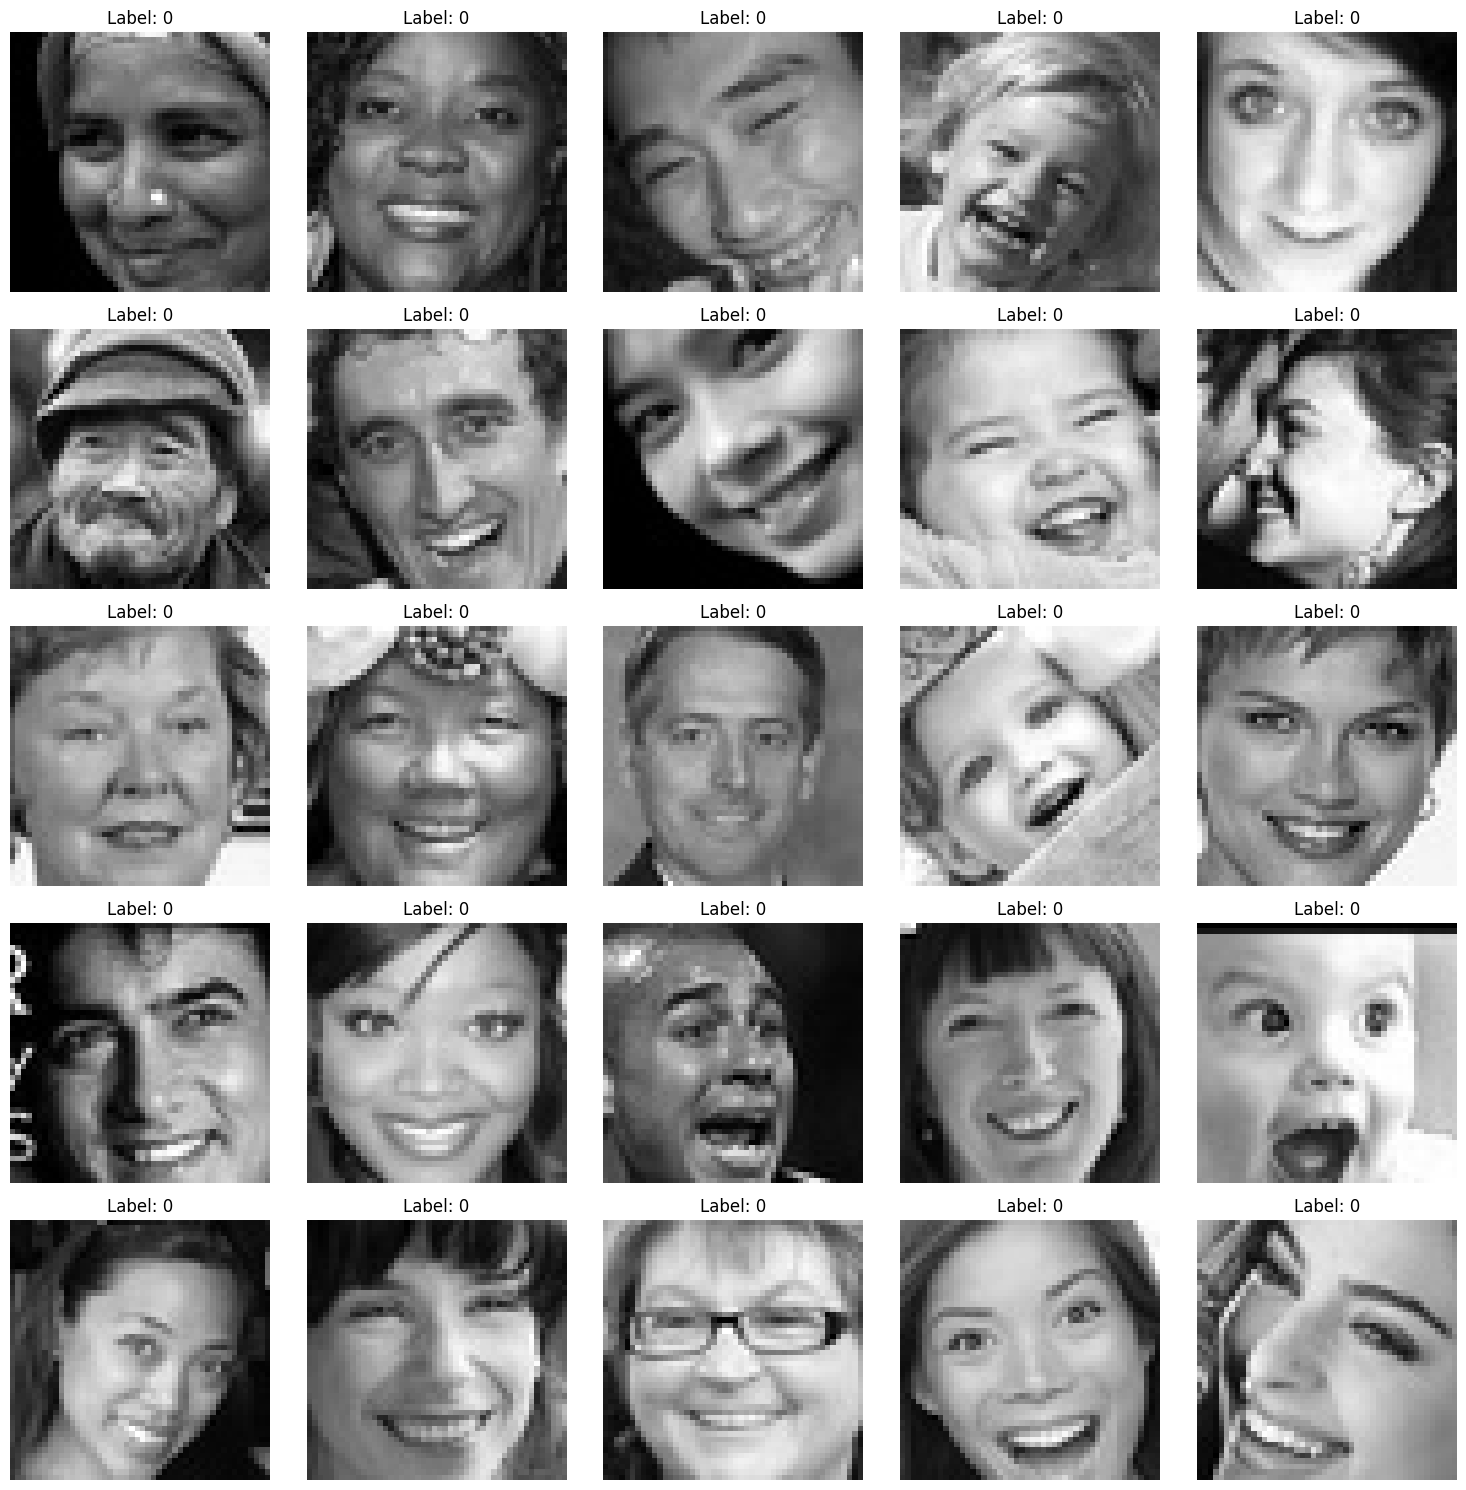

In [22]:
display_batch(train_tf)

In [23]:
import skimage as ski
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

In [24]:
def upscale(dataset, target_resolution):
  scale = target_resolution / dataset.element_spec['image'].shape[1]

  output_dataset = dataset.map(lambda sample: {
    'image': np.repeat(sample['image'], 3).reshape(dataset.element_spec['image'].shape[1], dataset.element_spec['image'].shape[1], 3),
    'label': sample['label']
  })

  output_dataset = dataset.map(lambda sample: {
    'image': tf.image.resize(sample['image'], [target_resolution, target_resolution]),
    'label': sample['label']
  })

  return output_dataset

def upscale(dataset, target_resolution):
    # Get the current image shape
    current_shape = dataset.element_spec['image'].shape

    def process_sample(sample):
        image = tf.repeat(sample['image'], 3, axis=-1)

        image = tf.image.resize(image, [target_resolution, target_resolution])

        return {'image': image, 'label': sample['label']}

    # Apply the transformation to the dataset
    output_dataset = dataset.map(process_sample)

    return output_dataset

In [25]:
target_resolution = 224

In [26]:
upscale_train_tf = upscale(train_tf, target_resolution)
upscale_test_tf = upscale(test_tf, target_resolution)

upscale_train_tf.element_spec, upscale_test_tf.element_spec

({'image': TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None),
  'label': TensorSpec(shape=(32,), dtype=tf.int64, name=None)},
 {'image': TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None),
  'label': TensorSpec(shape=(32,), dtype=tf.int64, name=None)})

# Define the Network

In [27]:
# First we will import the Linen API
from flax import linen as nn
import jax.numpy as jnp

In [28]:
class CNN(nn.Module):
  """A simple CNN model."""

  @nn.compact
  def __call__(self, x):
    # Layer One, Convolution Layer
    x = nn.Conv(features=96, kernel_size=(11, 11), strides=(4, 4))(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(3, 3), strides=(2, 2))

    # Layer Two, Convolution Layer
    x = nn.Conv(features=256, kernel_size=(5, 5))(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(3, 3), strides=(2, 2))

    # Layer Three, Convolution Layer
    x = nn.Conv(features=384, kernel_size=(3, 3))(x)
    x = nn.relu(x)

    # Layer Four, Convolution Layer
    x = nn.Conv(features=384, kernel_size=(3, 3))(x)
    x = nn.relu(x)

    # Layer Five, Convolution Layer
    x = nn.Conv(features=256, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(3, 3), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))

    # Layer Six, Fully Connected
    x = nn.Dense(features=4096)(x)
    x = nn.relu(x)

    # Layer Seven, Fully Connected
    x = nn.Dense(features=4096)(x)
    x = nn.relu(x)

    # Layer Eight, Fully Connected
    x = nn.Dense(features=4)(x)

    return x

In [29]:
# Initialize the CNN
cnn = CNN()

# Print a visual table of the model layers
print(cnn.tabulate(jax.random.key(0), jnp.ones((1, 224, 224, 3)), compute_flops=True, compute_vjp_flops=True))


                                            CNN Summary                                             
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs          ┃ outputs         ┃ flops      ┃ vjp_flops  ┃ params          ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│         │ CNN    │ float32[1,224,… │ float32[1,4]    │ 2085015296 │ 6311807488 │                 │
├─────────┼────────┼─────────────────┼─────────────────┼────────────┼────────────┼─────────────────┤
│ Conv_0  │ Conv   │ float32[1,224,… │ float32[1,56,5… │ 213928512  │ 641519360  │ bias:           │
│         │        │                 │                 │            │            │ float32[96]     │
│         │        │                 │                 │            │            │ kernel:         │
│         │        │                 │                 │            │            │ float32

# Establishing a Training State

In [30]:
!pip install -q clu

In [31]:
from clu import metrics
# Import the dataclass we will use for training states
from flax.training import train_state

# Imports the Flax dataclass
from flax import struct

# Imports the optax optimizer (Standard Jax optimization library)
import optax

In [32]:
@struct.dataclass
class Metrics(metrics.Collection):
  accuracy: metrics.Accuracy
  loss: metrics.Average.from_output('loss')

In [33]:
# Now we will establish our own TrainState that will contain the clu metrics
class TrainState(train_state.TrainState):
  metrics: Metrics

def create_train_state(module, rng, learning_rate, momentum):
  """Creates an initial `TrainState`."""
  params = module.init(rng, jnp.ones([1, 224, 224, 3]))['params'] # initialize parameters by passing a template image
  tx = optax.sgd(learning_rate, momentum)
  return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty())

# Establish a Training Step

In [34]:
@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, batch['image'])

    # Define our loss function to use the softmax_cross_entropy
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
    return loss

  # Generate the gradient of the loss function
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)

  # Apply the gradient
  state = state.apply_gradients(grads=grads)
  return state

In [35]:
@jax.jit
def compute_metrics(*, state, batch):
  logits = state.apply_fn({'params': state.params}, batch['image'])

  # Generates our Loss
  loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
  metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=batch['label'], loss=loss)

  # Generates our Metrics
  metrics = state.metrics.merge(metric_updates)
  state = state.replace(metrics=metrics)
  return state

In [36]:
num_epochs = 10
batch_size = 128

In [37]:
tf.random.set_seed(0)

In [38]:
init_rng = jax.random.key(0)

In [39]:
learning_rate = 0.0001
momentum = 0.9

In [40]:
state = create_train_state(cnn, init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

In [41]:
# since train_ds is replicated num_epochs times in get_datasets(), we divide by num_epochs
num_steps_per_epoch = upscale_train_tf.cardinality().numpy() // num_epochs

In [42]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [43]:
for step,batch in enumerate(upscale_train_tf.as_numpy_iterator()):

  # Run optimization steps over training batches and compute batch metrics
  state = train_step(state, batch) # get updated train state (which contains the updated parameters)
  state = compute_metrics(state=state, batch=batch) # aggregate batch metrics

  if (step+1) % num_steps_per_epoch == 0: # one training epoch has passed
    for metric,value in state.metrics.compute().items(): # compute metrics
      metrics_history[f'train_{metric}'].append(value) # record metrics
    state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

    # Compute metrics on the test set after each training epoch
    test_state = state
    for test_batch in upscale_test_tf.as_numpy_iterator():
      test_state = compute_metrics(state=test_state, batch=test_batch)

    for metric,value in test_state.metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)

    print(f"train epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['train_loss'][-1]}, "
          f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
    print(f"test epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

train epoch: 1, loss: 0.4953877329826355, accuracy: 82.421875
test epoch: 1, loss: 1.4132609367370605, accuracy: 25.0
train epoch: 2, loss: 0.647759199142456, accuracy: 74.27833557128906
test epoch: 2, loss: 1.46159827709198, accuracy: 25.0
train epoch: 3, loss: 0.6799423694610596, accuracy: 73.0137710571289
test epoch: 3, loss: 1.5052143335342407, accuracy: 25.0
train epoch: 4, loss: 0.7047078609466553, accuracy: 72.86149597167969
test epoch: 4, loss: 1.558753252029419, accuracy: 25.0
train epoch: 5, loss: 0.7539829611778259, accuracy: 71.61679077148438
test epoch: 5, loss: 1.527777910232544, accuracy: 25.0
train epoch: 6, loss: 0.6748117208480835, accuracy: 74.74840545654297
test epoch: 6, loss: 1.7322533130645752, accuracy: 25.0
train epoch: 7, loss: 0.6492314338684082, accuracy: 77.734375
test epoch: 7, loss: 1.6010805368423462, accuracy: 25.0
train epoch: 8, loss: 0.7688189148902893, accuracy: 71.81541442871094
test epoch: 8, loss: 1.5880837440490723, accuracy: 25.0
train epoch: 9

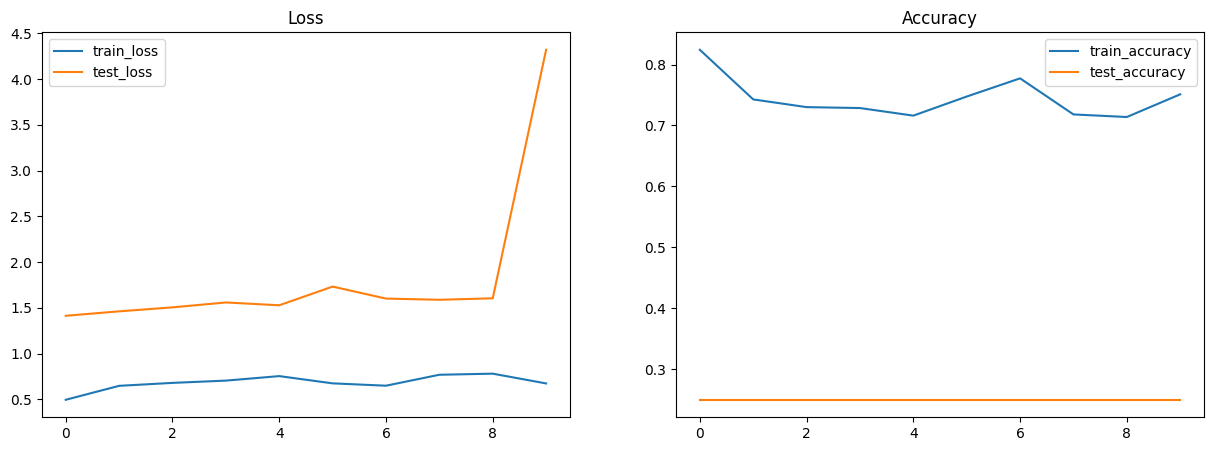

<Figure size 640x480 with 0 Axes>

In [44]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [45]:
@jax.jit
def pred_step(state, batch):
  logits = state.apply_fn({'params': state.params}, test_batch['image'])
  return logits.argmax(axis=1)

test_batch = upscale_test_tf.as_numpy_iterator().next()
pred = pred_step(state, test_batch)

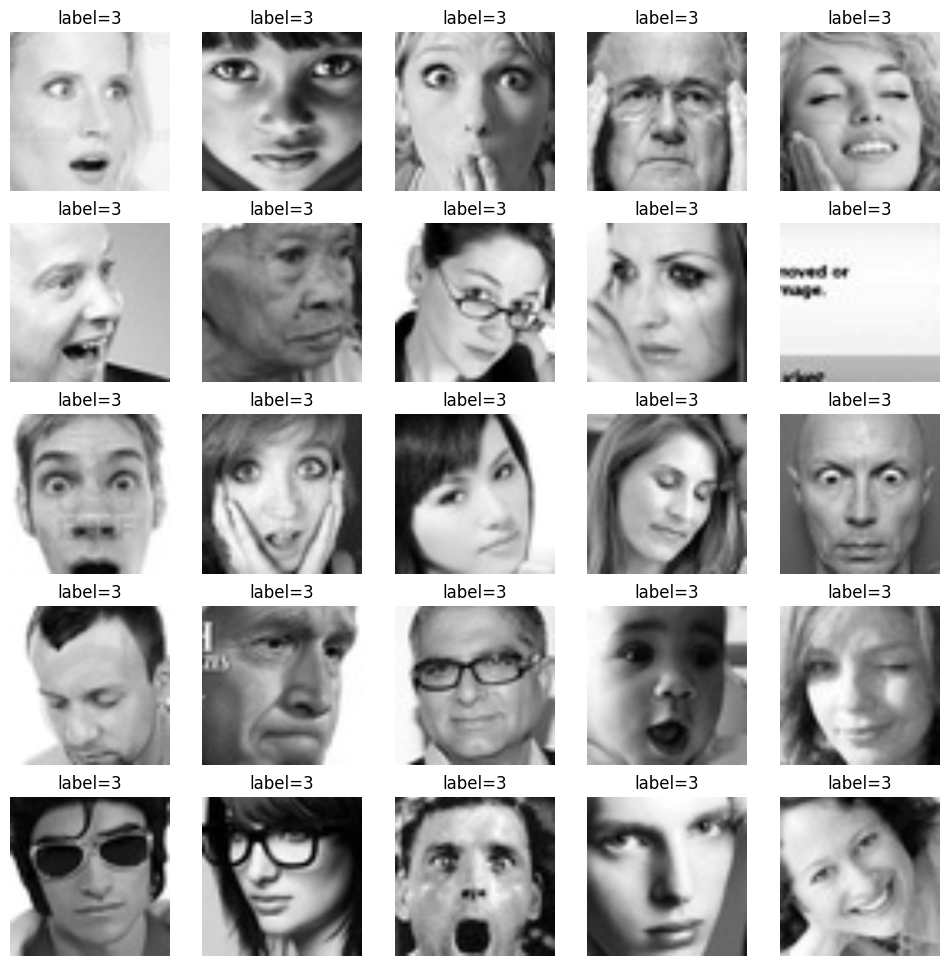

In [46]:
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(test_batch['image'][i, ..., 0], cmap='gray')
    ax.set_title(f"label={pred[i]}")
    ax.axis('off')

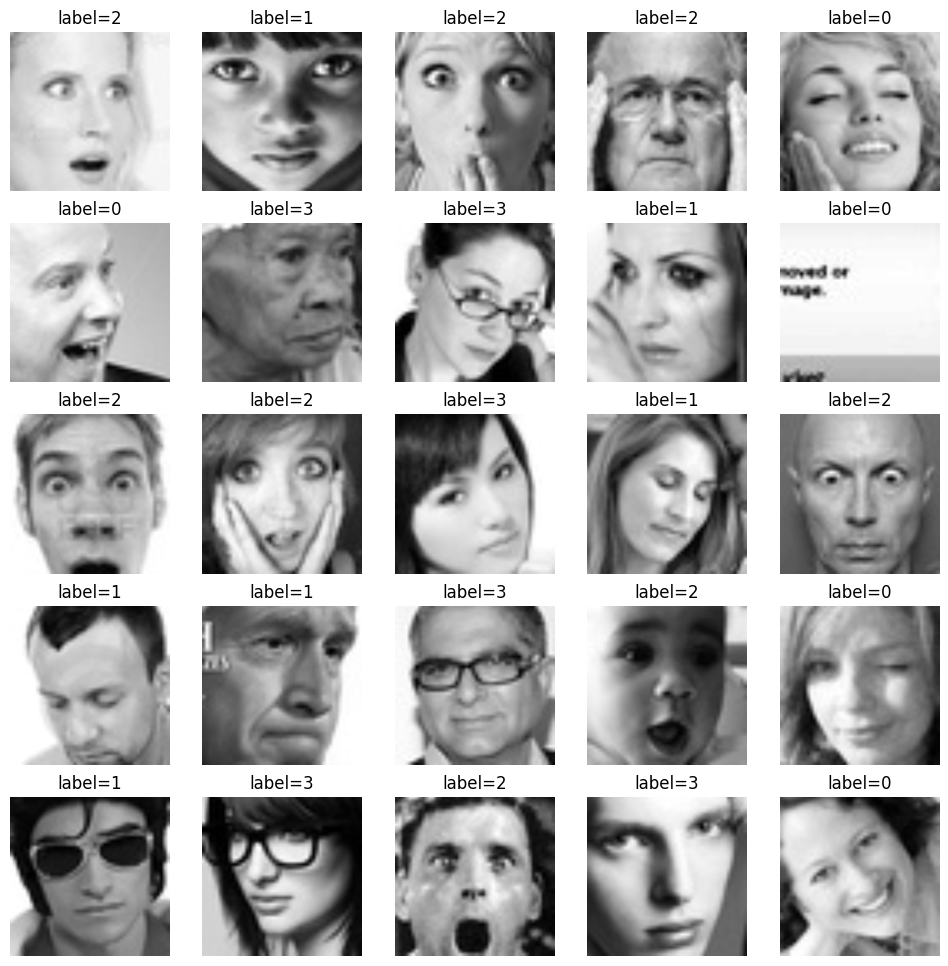

In [47]:
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(test_batch['image'][i, ..., 0], cmap='gray')
    ax.set_title(f"label={test_batch['label'][i]}")
    ax.axis('off')